# Exploratory Data Analysis (EDA): Human Resources Dataset

The goal of this EDA is to conduct a preliminary exploration of the IBM Human Resources (HR) dataset for general patterns and relationships which will aid in the development of a classification model for determining an employee's likelihood to quit.

In [1]:
# Import relevant packages

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import t

import statistics

Let's begin by reading in the cleaned DataFrame and refreshing our knowledge of the features.

In [2]:
# Read in cleaned DataFrame & Data Dictionary for reference
df = pd.read_csv('HR_data_cleaned.csv')
dictionary = pd.read_excel('data_dictionary.xlsx')

# Make a copy of the original HR data for reference
df_copy = df.copy()

# Get DataFrame column names
cols = df.columns

# Get numerical columns
df_stats = df.describe()
HR_num = df[df_stats.columns]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4382 non-null   int64  
 1   Age                      4382 non-null   int64  
 2   Attrition                4382 non-null   object 
 3   BusinessTravel           4382 non-null   object 
 4   Department               4382 non-null   object 
 5   DistanceFromHome         4382 non-null   float64
 6   Education                4382 non-null   int64  
 7   EducationField           4382 non-null   object 
 8   EmployeeCount            4382 non-null   int64  
 9   Gender                   4382 non-null   object 
 10  JobLevel                 4382 non-null   int64  
 11  JobRole                  4382 non-null   object 
 12  MaritalStatus            4382 non-null   object 
 13  MonthlyIncome            4382 non-null   float64
 14  NumCompaniesWorked      

Let's also declare a function that will be used later: Empirical Cumulative Distribution Function or ECDF.

In [3]:
### Function Declarations ###

# Declare Empirical Cumulative Distribution (ECDF) function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

Let's drop a few features which are constant for all employees, and so not particularly useful in this EDA. We will also do a quick conversion from monthly income to salary for ease of understanding.

In [4]:
### Data Cleaning ### 

# Data Cleaning: Drop constant features
df = df.drop(labels=['EmployeeCount','StandardHours','Over18'], axis=1)

# Convery monthly income to annual salary
df['MonthlyIncome'] = df['MonthlyIncome'].apply(lambda x: x*12)
df.rename(columns={'MonthlyIncome':'Salary'}, inplace=True)

Let's add a few features ('PaytoEffortRatio', 'SatisfactionRatio', 'DevelopmentRatio', and 'FlightRatio') to our DataFrame that we will see are particularly useful in determining whether an employee will quit ('Attrition').

In [5]:
### Feature Engineering ###

# Create PayToEffortRatio feature
df['PaytoEffortRatio'] = (df['Salary'])/(df['SumHrsWorked'])

# Create SatisfactionRatio feature
df['SatisfactionRatio'] = (df['WorkLifeBalance']*df['EnvironmentSatisfaction']*df['JobSatisfaction'])/(df['MeanHrsWorked'])

# Create DevelopmentRatio feature 
df['DevelopmentRatio'] = (df['TrainingTimesLastYear']+df['JobLevel']+df['StockOptionLevel'])/(1+df['YearsSinceLastPromotion'])

# Create FlightRatio feature, which describes potential for employee to leave
df['FlightRatio'] =(df['NumCompaniesWorked']) / (df['TotalWorkingYears']*df['EnvironmentSatisfaction'])

# Clean 'inf' values from FlightRatio caused by 'TotalWorkingYears' == 0 in denominator
df.replace([np.inf, -np.inf], np.NaN, inplace=True)

It may be easier to spot trends within age cohorts if we create some age bins for employees, so let's do that and then calculate the percent attrition in each age group.

We will also calculate attrition statistics for employees within various business travel frequency categories to examine the effect of travel on attrition.

In [6]:
### Grouping Data ###

# Generate bins for ages 
age_ranges = [i for i in range(np.min(df.Age),np.max(df.Age)+6,6)]
age_labels = ['18-23','24-29','30-35','36-41','42-47','48-53','54-59']

# Create ordered DataFrame of travel frequency labels
trv_labels = pd.DataFrame({'BusinessTravel':df.BusinessTravel.unique()}).sort_values(by='BusinessTravel')

# Sort employees into age bins
df['AgeGroup'] = pd.cut(df['Age'], bins=age_ranges, labels=age_labels, right=False)

# Calculate employee means by age
age_means = df.groupby('AgeGroup').agg([np.mean])
trv_means = df.groupby('BusinessTravel').agg([np.mean])

# Map attrition to 1/0 for 'Yes' or 'No'
attrition_map = {'Yes': 1, 'No': 0}
attrition_df = df.replace({'Attrition':attrition_map})

# Calculate attrition by age group (number of employees)
age_att_count = pd.DataFrame(attrition_df[['AgeGroup','Attrition']].value_counts())

# Calculate attrition by business travel frequency (number of employees)
trv_att_count = pd.DataFrame(attrition_df[['BusinessTravel','Attrition']].value_counts())

# Rename column to 'Count' for readability
age_att_count.rename(columns={0:'Count'}, inplace=True)
trv_att_count.rename(columns={0:'Count'}, inplace=True)

# Sort DataFrames by grouped feature
age_att_count = age_att_count.sort_values(by='AgeGroup')
trv_att_count = trv_att_count.sort_values(by='BusinessTravel')

# Extract the total number of employees per age group, and per business travel frequency via list comprehension
age_att_denom = np.array([age_att_count['Count'][i]+age_att_count['Count'][i+1] for i in range(0,len(age_att_count),2)])
trv_att_denom = np.array([trv_att_count['Count'][i]+trv_att_count['Count'][i+1] for i in range(0,len(trv_att_count),2)])

# Extract the total number of employees who quit per age group and business travel frequency via list comprehension
age_att_numer = np.array([age_att_count['Count'][i+1] for i in range(0,len(age_att_count),2)])
trv_att_numer = np.array([trv_att_count['Count'][i+1] for i in range(0,len(trv_att_count),2)])

# Create new DataFrames containing PercentAttrition by AgeGroup and BusinessTravel
attrition_perc_by_age = pd.DataFrame({'AgeGroup':age_labels,'PercentAttrition':(age_att_numer/age_att_denom)*100})
attrition_perc_by_trv = pd.DataFrame({'BusinessTravel':trv_labels.BusinessTravel,'PercentAttrition':(trv_att_numer/trv_att_denom)*100})

# Calculate employee means by category for Attrition vs. Non-Attrition
attrition_means = df.groupby('Attrition').agg([np.mean]).T

Now, we want to find out by how much (ex. by what percent) the mean of each feature (ex. Salary) is different between employees who have quit (Attrition = 'Yes'), and those who havent (Attrition = 'No'). 

We will store the result of this analysis in the 'attrition_means' DataFrame, and prepare the results for a barplot. We'll also make a version of this DataFrame without 'FlightRatio' for reasons that will soon become apparent.

In [7]:
### Data Wrangling for Barplots ###

# Create a column for the PercentChange in a given feature between employees who have quit and those who havent
attrition_means['PercentChange'] = ((attrition_means.Yes-attrition_means.No)/(attrition_means.No))*100

# Sort the DataFrame by the percent change to find the categories of largest difference (perhaps the most explanatory?)
attrition_means = attrition_means.iloc[(-np.abs(attrition_means['PercentChange'].values)).argsort()]

# Make a copy and remove FlightRatio
means_no_flight = attrition_means.iloc[1:len(attrition_means)]

# Remove multi-index and add features as a column
attrition_means.index = attrition_means.index.droplevel(1)
attrition_means.reset_index(inplace=True)

# Perform the same operation as above for the DataFrame without FlightRatio
means_no_flight.index = means_no_flight.index.droplevel(1)
means_no_flight.reset_index(inplace=True)

age_means.columns = age_means.columns.droplevel(1)
age_means.reset_index(inplace=True)

# Reshape the attrition DataFrame for a Barplot
barplot_means = pd.melt(attrition_means,id_vars=['index','PercentChange'],value_vars=['No','Yes'])

# Create a barplot input DataFrame without the FlightRatio feature
barplot_means_no_flight = pd.melt(means_no_flight,id_vars=['index','PercentChange'],value_vars=['No','Yes'])

print(barplot_means)

                      index  PercentChange Attrition         value
0               FlightRatio     132.531064        No      0.128418
1      YearsWithCurrManager     -34.403102        No      4.367963
2         SatisfactionRatio     -31.498224        No      3.030602
3         TotalWorkingYears     -30.288922        No     11.868643
4            YearsAtCompany     -30.112077        No      7.367419
5          PaytoEffortRatio     -14.224701        No     52.594032
6   YearsSinceLastPromotion     -12.333214        No      2.236062
7           JobSatisfaction     -11.072891        No      2.777747
8        NumCompaniesWorked      11.001063        No      2.646451
9   EnvironmentSatisfaction     -10.892868        No      2.771944
10                      Age     -10.484376        No     37.567038
11            MeanHrsWorked       9.864507        No      7.200037
12             SumHrsWorked       9.864507        No   1792.809194
13             MaxHrsWorked       8.508071        No      8.42

After printing the 'barplot_means' DataFrame (created from 'attrition_means'), we can see that there are several features whose mean values vary greatly between employees who have quit and those who havent (ex. 'FlightRatio', 'YearsWithCurrentManager', 'SatisfactionRatio', 'TotalWorkingYears', 'YearsAtCompany', 'PaytoEffortRatio'). It would seem that the differences in these feature means could be relatively strong predictors of attrition. 

Before we get to creating these Barplots, let's look at the general correlations between all numerical features with a correlation matrix:

# Feature Correlations

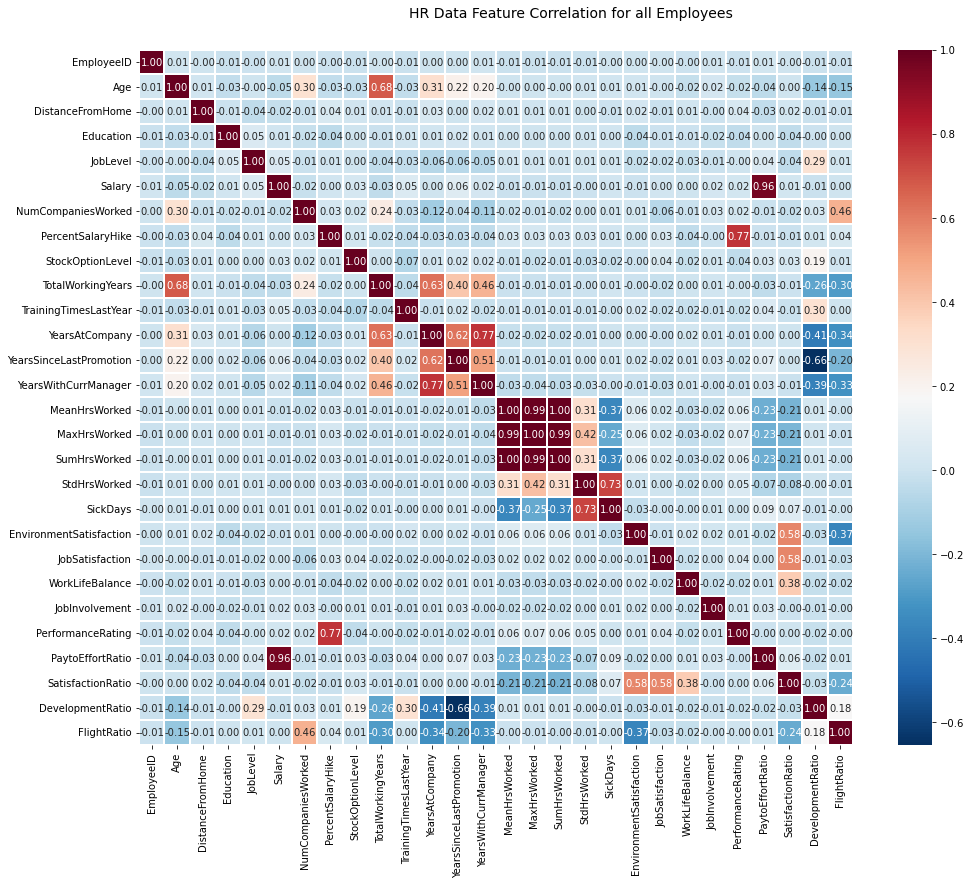

In [8]:
# Visualization: Correlation Matrix

# Correlation heatmap examining correlation of all features in the HR Dataset
corrmat = df.corr()
f, ax = plt.subplots(figsize=(16, 12))
hm = sns.heatmap(corrmat, annot=True, ax=ax, cmap="RdBu_r",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('HR Data Feature Correlation for all Employees', fontsize=14)
plt.show()

It would seem that most features share little correlation, with several notable exceptions. There appears to be a significant positive correlation between ('PercentSalaryHike', 'PerformanceRating') among several more intuitive correlations relating to employee age: ('Age', 'TotalWorkingYears'/'YearsAtCompany'/'NumCompaniesWorked'). There are also a handful of stronger correlations relating to the number of hours worked (daily), and the number of an employee's sick days. 

Let's visualize the scatterplots produced by these correlations with a pairplot: 

(NOTE: Plotting for the pairplot is off by default due to the excessive computation time required to render.)

In [9]:
# Visualization: Dataset Pairplot 
# NOTE: COMPUTATIONALLY INTENSIVE

# Pairplot for sampling of all numeric variables avalable
    # sns.pairplot(HR_num.iloc[::10,:],  palette='Set1')
    # plt.show()

# Visualizations

Now that we have looked at the correlations in our data more generally, let's create those barplots we prepared DataFrames for earlier.

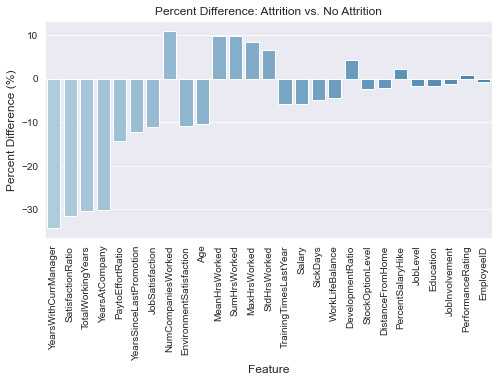

In [10]:
# Visualization: Attrition Barplot without FlightRatio

# Set the color palette
pal = sns.color_palette('Blues_d',len(barplot_means_no_flight))

# Create a barplot of the percent difference in features between employees who have quit and those who haven't
plt.figure(figsize=(8,4))
_ = sns.set_style('darkgrid')
sns.barplot(x="index", y="PercentChange", data=barplot_means_no_flight,palette=pal)

# Label the plot and rotate ticks
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Feature', fontsize=12)
_ = plt.ylabel('Percent Difference (%)', fontsize=12)
_ = plt.title('Percent Difference: Attrition vs. No Attrition', fontsize=12)

# Show the plot
plt.show()

We can see above that the feaures we noted earlier show significant diffences between employees who quit, and those who havent ('YearsWithCurrentManager', 'SatisfactionRatio', 'TotalWorkingYears', 'YearsAtCompany', 'PaytoEffortRatio'). 

Notably, it seems that employees that are more likely to quit have spent with fewer years at the company, are generally being payed less per hour ('PaytoEffortRatio'), and have a lower job and environment satisfaction ('SatisfactionRatio'). These are intuitive findings but interesting nonetheless.

Now, let's see what this barplot looks like with FlightRatio. Remember: 

FlightRatio = 'NumCompaniesWorked' / ('TotalWorkingYears' * 'EnvironmentSatisfaction')

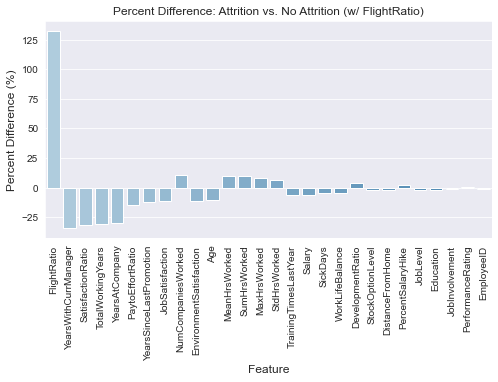

In [11]:
# Visualization: Attrition Barplot with FlightRatio

# Set the color palette
pal = sns.color_palette('Blues_d',len(barplot_means))

# Create a barplot of the percent difference in features between employees who have quit and those who haven't
plt.figure(figsize=(8,4))
_ = sns.set_style('darkgrid')
sns.barplot(x="index", y="PercentChange", data=barplot_means, palette=pal)

# Label the plot and rotate ticks
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Feature', fontsize=12)
_ = plt.ylabel('Percent Difference (%)', fontsize=12)
_ = plt.title('Percent Difference: Attrition vs. No Attrition (w/ FlightRatio)', fontsize=12)

# Show the plot
plt.show()

Wow! FlightRatio shows by far the greatest difference in mean value between employees who quit, and those who don't. This will likely be a very useful feature when predicting employee attrition.

Let's go back to the age groupings we made earler, and plot attrition rate (percentage) by age group.

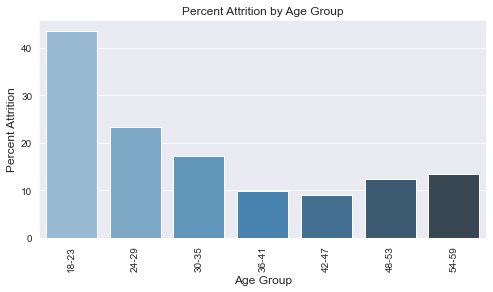

In [12]:
# Visualization: Age Barplot

# Set the color palette
pal = sns.color_palette('Blues_d',len(attrition_perc_by_age))

plt.figure(figsize=(8,4))
_ = sns.set_style('darkgrid')
sns.barplot(x='AgeGroup', y='PercentAttrition', data=attrition_perc_by_age,palette=pal)
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Age Group', fontsize=12)
_ = plt.ylabel('Percent Attrition', fontsize=12)
_ = plt.title('Percent Attrition by Age Group', fontsize=12)
plt.show()

It appears that younger employees (18-23, 24-29) disproportionately leave the company early. This corroborates our barplot finding that employees with fewer 'TotalWorkingYears' seem to quit at higher rates.

Next, let's look at the distributions for a few of the features that were identified on our first barplot to be quite different between employees who quit and those who haven't, such as 'TotalWorkingYears', 'NumCompaniesWorked', and 'MeanHrsWorked' (daily).

First, we'll have to do some quick data wrangling.

In [13]:
# BoxPlot Data Wrangling

# Create DataFrames for employees with Attrition = Yes/No
df_att = df[df['Attrition'] =='Yes']
df_no_att = df[df['Attrition'] =='No']

# Caluclate mean values for Box plots
box_means = df.groupby('Attrition')[['TotalWorkingYears','NumCompaniesWorked','MeanHrsWorked']].agg(np.mean)
box_means = np.round(box_means,2)

# Melt DataFrame for Box plot input
box_means = pd.melt(box_means,value_vars=['TotalWorkingYears','NumCompaniesWorked','MeanHrsWorked'])
box_means = box_means.value.to_list()

Now, we can create our box plots.

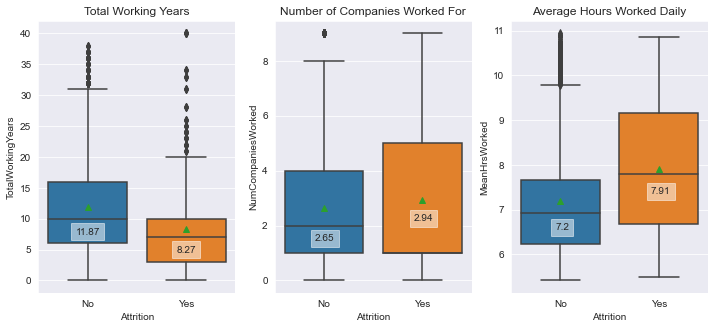

In [14]:
# Visualization: Box plots
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(12,5))
_ = sns.set_style('darkgrid')

box = sns.boxplot(ax=axes[0], x='Attrition',y='TotalWorkingYears',data=df,showmeans=True)
_ = axes[0].set_title('Total Working Years', fontsize=12)

_ = sns.boxplot(ax=axes[1], x='Attrition',y='NumCompaniesWorked',data=df,showmeans=True)
_ = axes[1].set_title('Number of Companies Worked For', fontsize=12)

_ = sns.boxplot(ax=axes[2], x='Attrition',y='MeanHrsWorked',data=df,showmeans=True)
_ = axes[2].set_title('Average Hours Worked Daily', fontsize=12)

# List label positions for feature mean values
x_pos = [-4.8, -3.8, -2.39, -1.39, 0.02, 1.02]
y_pos = [6.5, 6.1, 6.35, 6.8, 6.6, 7.4]

# Place labels on the plots
for i in range(len(box_means)):
    plt.text(x_pos[i], y_pos[i], box_means[i],
         bbox=dict(facecolor='white', alpha=0.5),
         horizontalalignment='center',verticalalignment='center',
         fontsize=10)
    
# Show the plot
plt.show()

There seem to be some large differences in the mean values (labeled) between the features examined for employees who have quit versus those who haven't. 

To determine whether these differences are statistically significant between samples, let's calculate some 't' and 'p' test statistics:

In [15]:
# Statistical testing for relationships shown in Box plots
# Determine if means are significantly different between Attrition/No Attrition

# Using SciPy to calculate t and p  statistics for each:
t_wrk, p_wrk = stats.ttest_ind(df_att['TotalWorkingYears'], df_no_att['TotalWorkingYears'])

t_comp, p_comp = stats.ttest_ind(df_att['NumCompaniesWorked'], df_no_att['NumCompaniesWorked'])

t_meanhrs, p_meanhrs = stats.ttest_ind(df_att['MeanHrsWorked'], df_no_att['MeanHrsWorked'])

print("t (Total Working Years): ", np.round(t_wrk,3))
print("p (Total Working Years): ", p_wrk, '\n')

print("t (Number of Companies Worked For): ", np.round(t_comp,3))
print("p (Number of Companies Worked For): ", p_comp, '\n')

print("t (Mean Daily Hours Worked): ", np.round(t_meanhrs,3))
print("p (Mean Daily Hours Worked): ", p_meanhrs, '\n')

t (Total Working Years):  -11.394
p (Total Working Years):  1.1645434967153693e-29 

t (Number of Companies Worked For):  2.837
p (Number of Companies Worked For):  0.004572057121646456 

t (Mean Daily Hours Worked):  13.23
p (Mean Daily Hours Worked):  3.2873306234986727e-39 



Based upon the P << 0.05 established for each feature, we can confidently state that the differences in TotalWorkingYears', 'NumCompaniesWorked', and 'MeanHrsWorked' are statistically significant between employees who have quit and those who haven't. The calculated P values are corroborated by relatively large t-values.

Now we can feel better about potentially using these features and their differences to predict attrition.

Let's continue our EDA by looking at some general distibutions of features like 'Education', 'Job Role' 'Salary' and 'Attrition' to see if interesting patterns arise in our analysis.

First, some data wrangling:

In [16]:
# Pre-visualization Data Wrangling

# Sample every 10th row for cleaner plotting
sample_edu = df[['Education','Salary','JobLevel']].sort_values(by='Education').iloc[::10,:]

# Create mapping from integers to education level
mapping_edu = {1:'High School', 2:'Associates', 3:'Bachelors', 4:'Masters', 5:'Doctorate'}

# Apply mapping to education level data
sample_edu = sample_edu.replace({'Education':mapping_edu})

Now, let's create a swarmplot to group employees by 'JobLevel' (ex. I: 'entry level', III: 'senior level', etc.) and examine the relationship between 'Salary' and the employees' highest attained 'Education'.

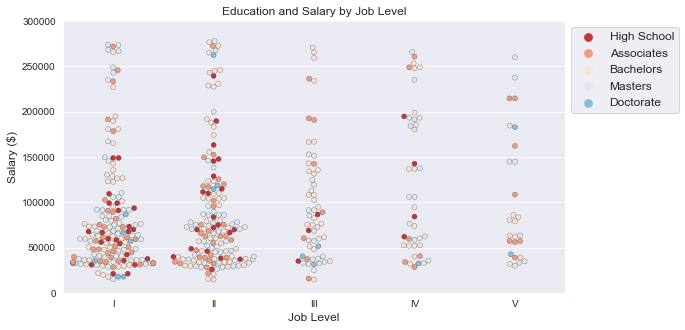

In [17]:
# Visualization: Education, Salary, and Job Level Swarmplot
_ = plt.figure(figsize=(9,5))
_ = sns.set_style('darkgrid')
_ = sns.set_palette('RdBu')
_ = sns.swarmplot(data=sample_edu,
            x='JobLevel',
            y='Salary', hue='Education',edgecolor='black',linewidth=0.20)

_ = plt.xlabel('Job Level', fontsize=12)
_ = plt.ylabel('Salary ($)', fontsize=12)
_ = plt.title('Education and Salary by Job Level', fontsize=12)
_ = plt.xticks(ticks = (0,1,2,3,4), labels=('I', 'II', 'III', 'IV', 'V'))
_ = plt.yticks(range(0,350000,50000))
_ = plt.legend(bbox_to_anchor=(1,1), fontsize=12)

_ = sns.despine()
_ = plt.savefig('Salary by Job Level & Education')
_ = plt.show()

Interestingly, most of the employees possessing a high-school level education also have a lower 'Salary' and lower 'JobRole' (ex. I: 'entry-level'). These employees seem to be filtered out at higher job levels, as those with higher degrees (ex. 'Bachelors' and 'Masters') make up a larger percentage of employees at higher job levels.

Let's continue our analysis by looking at the cross-relationship of several features determined to be important to attrition: 'Salary', 'WorkingHours', 'FlightRatio'. 

In this scatterplot visualiztion, we will scale each employee's data point by their 'FlightRatio' to help identify groupings and employees who may be at risk for Attrition.

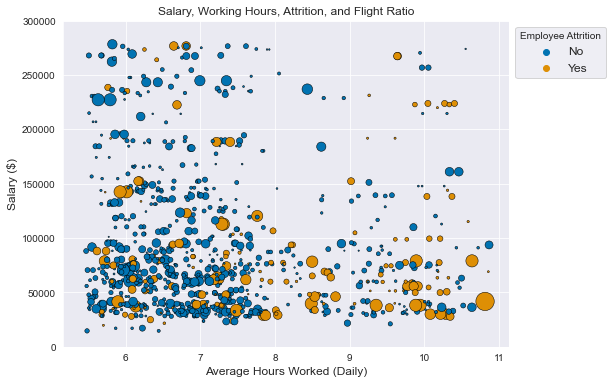

In [18]:
# Visualization: Salary, Working Hours, Attrition, and FlightRatio
scatter_sizes = df.iloc[::4,:]
scatter_sizes = scatter_sizes['FlightRatio']

_ = plt.figure(figsize=(8,6))
sns.set_palette('colorblind')
sns.scatterplot(x='MeanHrsWorked',y='Salary',data=df.iloc[::4,:], hue='Attrition' , s=scatter_sizes*150, sizes = (200,500),edgecolor='black',linewidth=0.50)

_ = plt.xlabel('Average Hours Worked (Daily)', fontsize=12)
_ = plt.ylabel('Salary ($)', fontsize=12)
_ = plt.yticks(range(0,350000,50000))
_ = plt.title('Salary, Working Hours, Attrition, and Flight Ratio', fontsize=12)
plt.legend(title='Employee Attrition', bbox_to_anchor=(1,1), fontsize=12)

plt.show()

Unsurprisingly, it appears that employees who are underpaid and work significantly more than 8 hours per day are at the greatest risk of attrition, as evidenced by the clustering of yellow in the lower-right corner. 

We can also see that 'Salary' plays an important role in keeping employees, as shown by the significant band of yellow on the bottom half of the plot.

Inversely, it appears that employees who are paid well and work fewer hours tend to quit at lower rates.

Let's continue our analysis of overwork by examining the effect of 'BusinessTravel' frequency and 'MeanHrsWorked' on employee attrition.

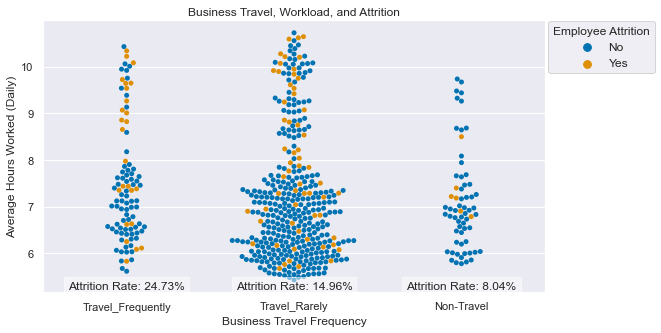

In [19]:
# Visualization: Attrition by Business Travel frequency and MeanHrsWorked

# Take a sample of the dataset for cleaner visualization
trvl_values = df[['Attrition','BusinessTravel','MeanHrsWorked']].iloc[::8,:]

sns.set(style="darkgrid")
sns.set_palette('colorblind')

_ = plt.figure(figsize=(9,5))
sns.swarmplot(data=trvl_values, x='BusinessTravel', y='MeanHrsWorked', hue='Attrition',order=['Travel_Frequently','Travel_Rarely','Non-Travel'])

_ = plt.title('Business Travel, Workload, and Attrition', fontsize=12)
_ = plt.xlabel('Business Travel Frequency', fontsize=12)
_ = plt.ylabel('Average Hours Worked (Daily)', fontsize=12)
plt.legend(title='Employee Attrition', bbox_to_anchor=(1.23,1.02), fontsize=12)

# Get attriton rate by BusinessTravel frequency list from previous calculations
trv_att_labels = sorted(attrition_perc_by_trv.PercentAttrition.to_list(),reverse=True)

# List label positions for mean attrition rate (percentage) values by BusinessTravel frequency
x_pos = [0, 1, 2]
y_pos = [5.3, 5.3, 5.3]

# Place labels on the plots
for i in range(len(attrition_perc_by_trv)):
    plt.text(x_pos[i], y_pos[i], 'Attrition Rate: '+str(np.round(trv_att_labels[i],2))+'%',
         bbox=dict(facecolor='white', alpha=0.5),
         horizontalalignment='center',verticalalignment='center',
         fontsize=12)

plt.show()

We can see here that not only do employees who travel more frequently quit at higher rates (frequently: 24.73%, rarely: 14.96%, non-travel: 8.04%), and those who quit work more hours per day on average (note the prevalence of yellow at the top of the plot). It is also shown that employees that rarely travel make up the majority of the company.

Next, let's continue our analysis of company trends to see if there are noticable differences between company departments with regard to the number of hours worked daily:

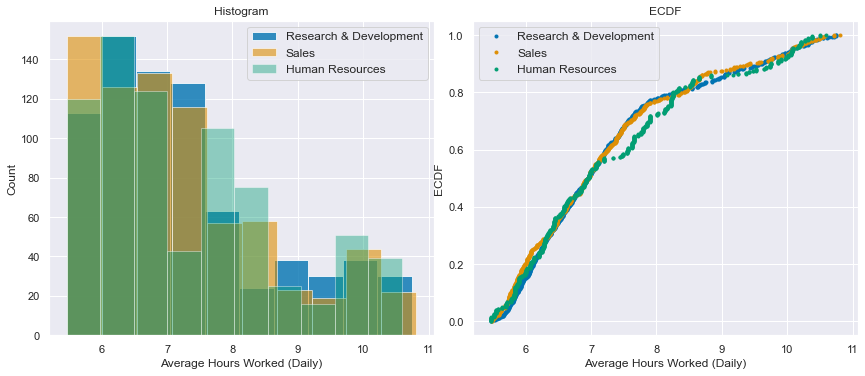

In [20]:
# Visualization: Worked Hours and Department Histogram and ECDF

dept_hrs = df[['Department','MeanHrsWorked']]

hrs_sales = dept_hrs[dept_hrs['Department'] == 'Sales'].sample(n=750, replace=True)
hrs_rsrch = dept_hrs[dept_hrs['Department'] == 'Research & Development'].sample(n=750, replace=True)
hrs_hures = dept_hrs[dept_hrs['Department'] == 'Human Resources'].sample(n=750, replace=True)

x_sales, y_sales = ecdf(hrs_sales['MeanHrsWorked'])
x_rsrch, y_rsrch = ecdf(hrs_rsrch['MeanHrsWorked'])
x_hures, y_hures = ecdf(hrs_hures['MeanHrsWorked'])

sns.set_style('darkgrid')
sns.set_palette('colorblind')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].hist(hrs_rsrch['MeanHrsWorked'], alpha=0.8)
axes[0].hist(hrs_sales['MeanHrsWorked'], alpha=0.6)
axes[0].hist(hrs_hures['MeanHrsWorked'], alpha=0.4)

axes[1].plot(x_rsrch, y_rsrch, marker='.', linestyle='none')
axes[1].plot(x_sales, y_sales, marker='.', linestyle='none')
axes[1].plot(x_hures, y_hures, marker='.', linestyle='none')

fig.tight_layout()

axes[0].set_title('Histogram', fontsize=12)
axes[0].set_xlabel('Average Hours Worked (Daily)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(['Research & Development','Sales', 'Human Resources'], fontsize=12)

axes[1].set_title('ECDF', fontsize=12)
axes[1].set_xlabel('Average Hours Worked (Daily)', fontsize=12)
axes[1].set_ylabel('ECDF', fontsize=12)
axes[1].legend(['Research & Development','Sales', 'Human Resources'], fontsize=12)

_ = plt.show()

The differences between departments in terms of daily worked hours per employee don't appear to be very large, possibly due to company policy. However, there is a noticable peak near 9.5 hours/day exhibited by the 'Research & Development' department. 

Back when we examined the correlation matrix, we saw that there appeared to be a logical but substantial positive correlation between 'Age' and 'NumCompaniesWorked' (Number of Companies Worked For). Let's examine this relationship with a regression plot (and CI's) and calculate the strength of the correlation. 

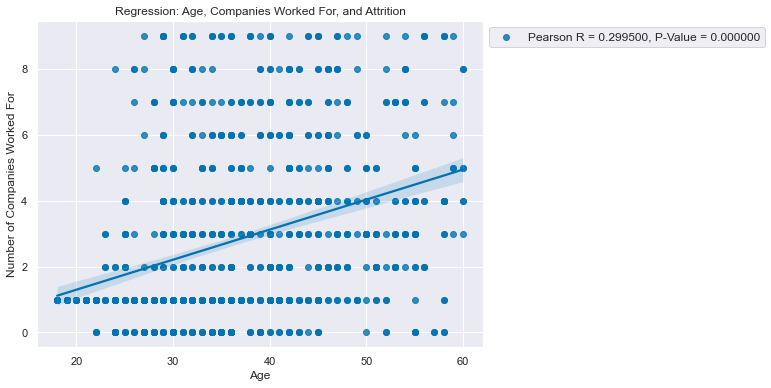

In [21]:
# Take a subset of the data for plotting
df_joint = df.iloc[::4,:]

# Visualization: Scatter
_ = plt.figure(figsize=(8,6))
sns.regplot(x='Age',y='NumCompaniesWorked',data=df_joint)

# Calculate the Pearson's R and P-value
r, p = stats.pearsonr(df['Age'],df['NumCompaniesWorked'])

_ = plt.xlabel('Age', fontsize=12)
_ = plt.ylabel('Number of Companies Worked For', fontsize=12)
_ = plt.title('Regression: Age, Companies Worked For, and Attrition', fontsize=12)

plt.legend(['Pearson R = {:f}, P-Value = {:f}'.format(np.round(r,4),np.round(p,5))], bbox_to_anchor=(1,1),fontsize=12)

# Show the plot
plt.show()

As calculated above, there appears to be a 'weak positive' correlation between these features (R = 0.29).

Let's continue our analysis of the relationship between these features by examining the spread of the data, and where employees who have quit are distributed among these points.

<Figure size 1296x1296 with 0 Axes>

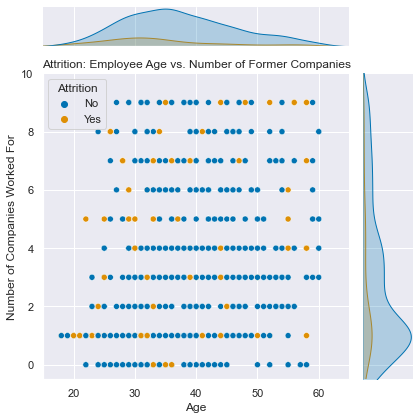

In [22]:
# Visualization: JointPlot
_ = plt.figure(figsize=(18,18))
plot = sns.jointplot(x='Age',y='NumCompaniesWorked', data=df_joint, hue='Attrition')


# Set X and Y axis labels
plot.ax_joint.set_xlabel('Age', fontsize=12)
plot.ax_joint.set_ylabel('Number of Companies Worked For', fontsize=12)
plot.ax_joint.set_title('Attrition: Employee Age vs. Number of Former Companies', fontsize=12)
plot.ax_marg_x.set_xlim(15, 65)
plot.ax_marg_y.set_ylim(-0.5, 10)
plot.fig.tight_layout()

# Show the plot
plt.show()

While the trend isn't obvious, there appears to be generally more employees who have quit on the left and upper sides of the plot, suggesting that those employees with a higher companies per year ratio generally quit at higher rates. 

# Conclusions

Primary findings from this EDA include the following:

A. The five features with the greatest difference in mean value for attritional versus non-attritional employees are:
    1. 'FlightRatio': +132.5% (a measure of the number of companies worked for per working year divided by job satisfaction)
    2. 'YearsWithCurrManager': -34.4%
    3. 'SatisfactionRatio': -31.5% (a measure of job satisfaction metrics divided by mean daily hours worked)
    4. 'TotalWorkingYears': -30.3%
    5. 'YearsAtCompany': -30.1%
    These features will likely prove to be useful in further analysis in determining the likelihood of employee attrition.
    
B. Attrition is disproportionately common among the 18-23, and 24-29 age demographics, as evidenced by higher mean attrition rates in these age groups (43.6%, 23.3% respectively) relative to the company-wide average rate (18.4%). This trend is corroborated by P << 0.05 for the 3.6 year mean reduction in 'TotalWorkingYears' between attritional vs. non-attritional employees.

C. Employees who on average work a greater number of hours per day ('MeanHrsWorked') tend to quit at a higher rate versus those working 8 hours or fewer per day. This trend is especially significant when adjusted for 'Salary', with employees possessing lower salaries and higher daily worked hour averages (i.e. underpaid and overworked employees) exhibiting the highest rates of attrition company-wide.


D. Employees possessing only a high-school degree disproportionately occupy the lowest-paying and entry to mid-level job roles within the company. Employees with at least an Associates degree or higher tend to have greater upward mobility into high-level roles. 

E. Business travel frequency has a large effect on employee attrition rates with more traveled employees quitting at higher rates (frequently: 24.73%, rarely: 14.96%, non-travel: 8.04%). Notably, the largest percentage of company employees fall into the 'Rarely-Travel' category. 

F. There exists a 'Weak Positive' correlation (R = 0.29) between employee 'Age' and 'NumCompaniesWorked'. Interestingly, employees who exhibit a greater ratio of companies worked for per year also tend to have higher attrition rates.